In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
import os

# Data preperation (emotions fer2013)

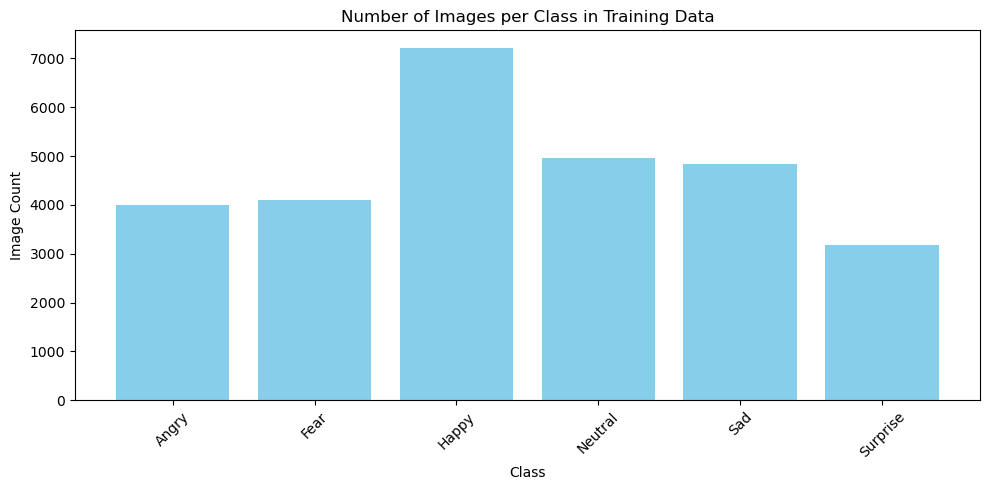

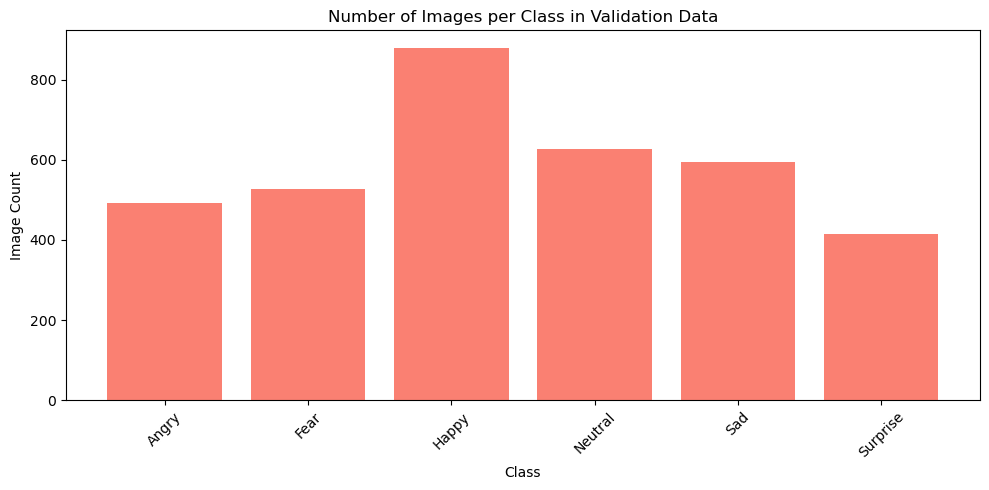

In [2]:
train_path = 'dataset/fer2013/train'
validation_path = 'dataset/fer2013/validation'

def count_images(directory):
    counts = {}
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):
            image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png'))]
            counts[subfolder] = len(image_files)
    return counts

train_counts = count_images(train_path)
val_counts = count_images(validation_path)

plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title("Number of Images per Class in Training Data")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(val_counts.keys(), val_counts.values(), color='salmon')
plt.title("Number of Images per Class in Validation Data")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    color_mode='grayscale',
                                                    target_size=(48,48),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                    color_mode='grayscale',
                                                    target_size=(48,48),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


# model

In [4]:
# for the most reliable face detector model Install the mtcnn package if not already installed by pip install mtcnn
# note that we use haarcascade_frontalface_default.xml for face detecting

import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN

# Initialize the MTCNN face detector
detector = MTCNN()

# Load an image
image_path = "face_image.jpg"
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Detect faces in the image
results = detector.detect_faces(image)

# Draw bounding boxes and keypoints on the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
ax = plt.gca()

for result in results:
    # Extract bounding box coordinates
    x, y, width, height = result['box']  
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally, draw keypoints (e.g., eyes, nose, mouth)
    for key, point in result['keypoints'].items():
        ax.plot(point[0], point[1], marker='o', markersize=5, color='blue')

plt.title("Face Detection with MTCNN")
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'mtcnn'

In [5]:
 # creating a model inspired by littleVGG architecture
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Activation, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (48, 48, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (48, 48, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(6, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

# training the emotions dataset

In [6]:
# training with our custom model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

os.makedirs('models',exist_ok=True)

early = EarlyStopping(monitor='val_loss',
                        patience=3,
                        verbose=2)

checkpoint = ModelCheckpoint(os.path.join("models","model2.h5"),
                                monitor = 'val_loss',
                                save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor = 0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs = 10,
    callbacks = [early,checkpoint,reduce_lr],
    validation_data = validation_generator,)

# visualizing

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join("models", 'model2.h5'))

In [13]:
test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# test accuracy is low because of incorrect classification, low epochs, unbalance categories and ...


221/221 [==============================] - 27s 121ms/step - loss: 1.2892 - accuracy: 0.5464
Test Loss: 1.2892273664474487
Test Accuracy: 0.5464063286781311


221/221 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

       Angry       0.15      0.16      0.15       491
        Fear       0.15      0.08      0.10       528
       Happy       0.26      0.30      0.27       879
     Neutral       0.16      0.10      0.12       626
         Sad       0.16      0.21      0.18       594
    Surprise       0.12      0.16      0.14       416

    accuracy                           0.18      3534
   macro avg       0.17      0.17      0.16      3534
weighted avg       0.18      0.18      0.17      3534



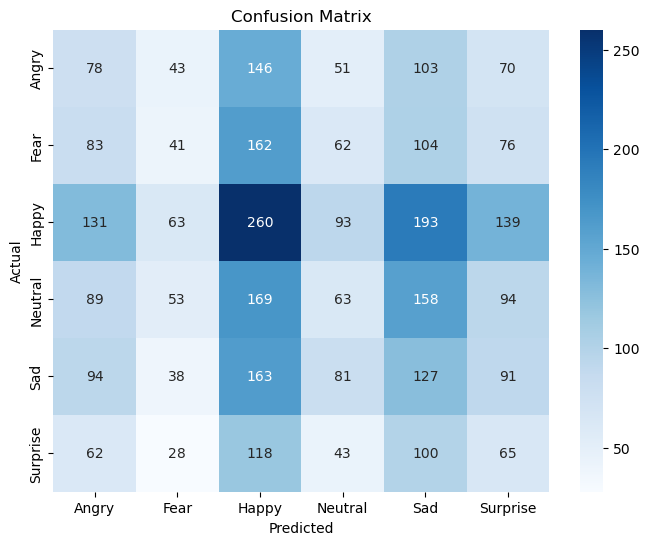

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = validation_generator.classes
y_pred = np.argmax(loaded_model.predict(validation_generator),axis=1)

class_names = os.listdir(validation_path)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true,y_pred,target_names=class_names))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 27ms/step


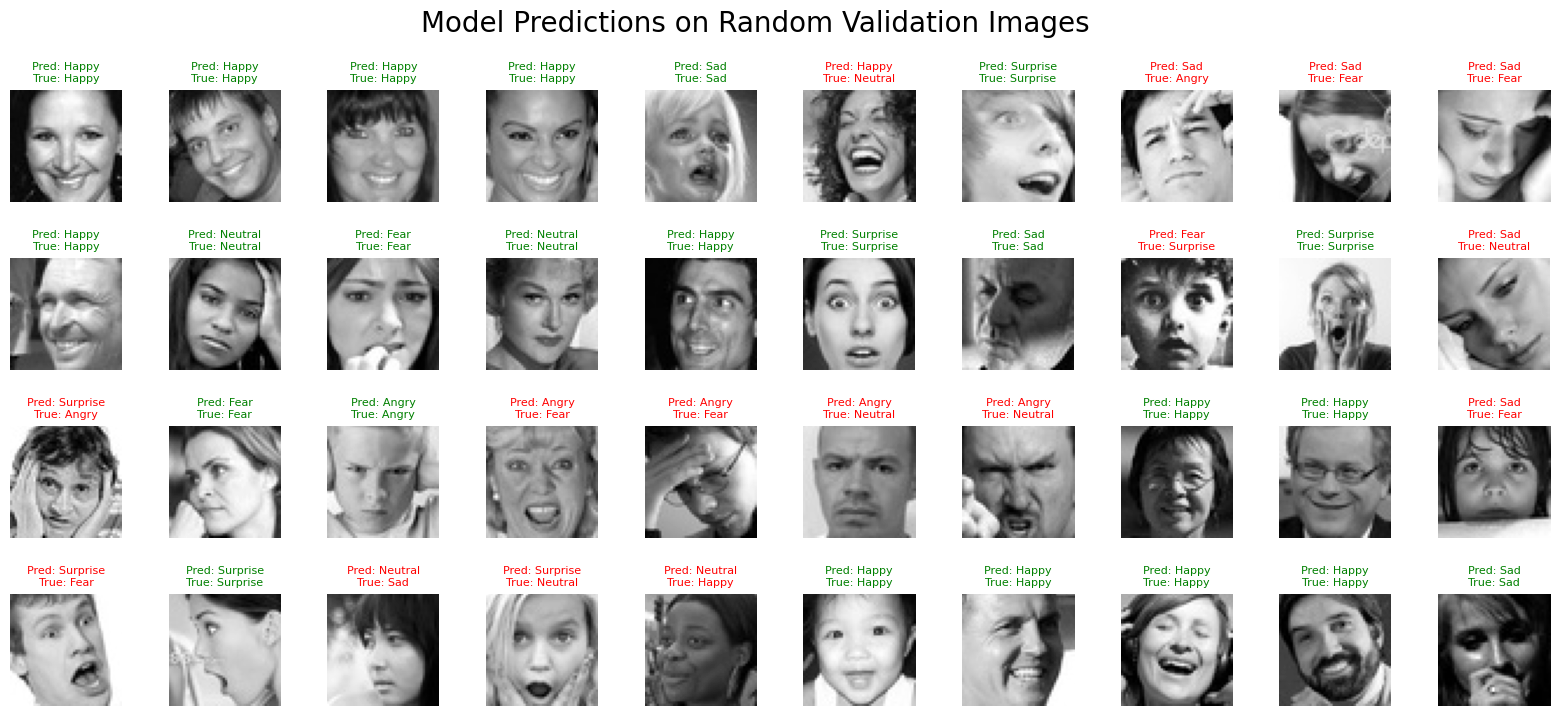

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from tensorflow.keras.models import load_model

image_files = []
image_labels = []

for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(validation_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_files.append(os.path.join(class_folder, img_file))
            image_labels.append(class_name)

random_indices = random.sample(range(len(image_files)), 40)
random_images = [image_files[i] for i in random_indices]
true_labels = [image_labels[i] for i in random_indices]

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))
fig.suptitle("Model Predictions on Random Validation Images", fontsize=20)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for idx, ax in enumerate(axes.flat):
    img_path = random_images[idx]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (48, 48))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    prediction = loaded_model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]

    ax.imshow(img_resized, cmap='gray')
    if predicted_class_name == true_labels[idx]:
        color = 'g'
    else:
        color = 'r'
    ax.set_title(f"Pred: {predicted_class_name}\nTrue: {true_labels[idx]}", fontsize=8, color=color)
    ax.axis("off")

plt.show()

# live (emotions)

In [6]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
class_names = os.listdir(validation_path)
model = load_model("models/model2.h5")

def face_detect(frame):
    frame = cv2.flip(frame,1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) == 0:
        return frame

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48))
        face_normalized = face_resized / 255.0
        face_array = np.expand_dims(face_normalized, axis=0)
        face_array = np.expand_dims(face_array, axis=-1)

        predict = np.argmax(model.predict(face_array))
        preds = model.predict(face_array)
        emotions={
            'happy' : (round(preds[0][2],2),20),
            'sad' : (round(preds[0][4],2),40),
            'suprise' : (round(preds[0][5],2),60),
            'neutral' : (round(preds[0][3],2),80),
            'angry' : (round(preds[0][0],2),100)}
        predicted_label = class_names[predict]
        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        for emotion, (percent,position) in emotions.items():
            if percent > 0.4:
                color = (0,255,0)
            else:
                color = (0,0,255)
            cv2.putText(frame, f"{emotion} : "+ str(percent), (10, position), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = face_detect(frame)
    
    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 22ms/step


# live (emotions, age, gender) persian

In [17]:
from pathlib import Path
import cv2
import os
import numpy as np
# import dlib # little better at age detecting but slower
import sys
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import arabic_reshaper
from bidi.algorithm import get_display
import argparse
from contextlib import contextmanager
from wide_resnet import WideResNet
from keras.utils.data_utils import get_file
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
pretrained_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.28-3.73.hdf5"
modhash = 'fbe63257a054c1c5466cfd7bf14646d6'
validation_path = 'dataset/fer2013/validation'
class_names = os.listdir(validation_path)
model = load_model("models/model2.h5")

# model parameters
depth = 16
k = 8
weight_file = None
margin = 0.4
image_dir = None

# Get our weight file 
weight_file = "models/weights.28-3.73.hdf5"
if not weight_file:
    weight_file = get_file("models/weights.28-3.74.hdf5", pretrained_model, cache_subdir="pretrained_models",
                           file_hash=modhash, cache_dir=Path(sys.argv[0]).resolve().parent)

# load model and weights
img_size = 64
model2 = WideResNet(img_size, depth=depth, k=k)()
model2.load_weights(weight_file)

def face_detect(frame):
    frame = cv2.flip(frame,1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))
    
    if len(faces) == 0:
        return frame

    face_resized_ag = []
    
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48))
        face_ag = cv2.resize(face, (64, 64), interpolation = cv2.INTER_AREA)
        face_ag = cv2.cvtColor(face_ag, cv2.COLOR_GRAY2RGB)
        face_resized_ag.append(face_ag)
        face_normalized = face_resized / 255.0
        face_array = np.expand_dims(face_normalized, axis=0)
        face_array = np.expand_dims(face_array, axis=-1)
        
        # prediction for Age and Gender
        results = model2.predict(np.array(face_resized_ag))
        predicted_genders = results[0]
        ages = np.arange(0, 101).reshape(101, 1)
        predicted_ages = results[1].dot(ages).flatten()
        
        # prediction for emotions
        predict = np.argmax(model.predict(face_array))
        preds = model.predict(face_array)
        emotions={
            'شاد' : (round(preds[0][2],2),20),
            'ناراحت' : (round(preds[0][4],2),40),
            'هیجان زده' : (round(preds[0][5],2),60),
            'خنثی' : (round(preds[0][3],2),80),
            'عصبانی' : (round(preds[0][0],2),100)}
        
        predicted_label = class_names[predict]        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, predicted_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        def overlay_text_on_frame(frame, text, position,text_color,font_size):
            font_path = "Vazir.ttf"    
            pil_image = Image.fromarray(frame)
            reshaped_text = arabic_reshaper.reshape(text)
            bidi_text = get_display(reshaped_text)
            font = ImageFont.truetype(font_path, font_size)
            draw = ImageDraw.Draw(pil_image)
            draw.text(position, bidi_text, font=font, fill=text_color)
            return np.array(pil_image)
            
        # draw results for Age and Gender
        for (i, face) in enumerate(faces):
            h, w, _ = frame.shape
            if len(faces) <=1:
                gender_text = "زن" if predicted_genders[i][0] > 0.6 else "مرد"
                label = f"{int(predicted_ages[i])}"
                age_text = f"جنسیت:\nسن:"
                frame = overlay_text_on_frame(frame, age_text, (w-80,20),(255,0,0),20)
                frame = overlay_text_on_frame(frame, gender_text, (w-110,20),(0,255,0),20)
                cv2.putText(frame,label,(w- 100,66),cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2)
            else :
                two_face = "دو چهره شناسایی شد !"
                frame = overlay_text_on_frame(frame,two_face, (250,10),(255,0,0),20)
        # draw results for emotions
        for emotion, (percent,position) in emotions.items():
            if percent > 0.4:
                color = (0,255,0)
            else:
                color = (0,0,255)
            frame = overlay_text_on_frame(frame, emotion, (10,position-20),color,20)
            cv2.putText(frame, str(percent), (100, position), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return frame
    

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = face_detect(frame)
    if frame is None:
        print("Error: Frame is empty. Check your function!")
        continue

    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(1) & 0xFF == 27: # Esc key
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
